# Lab 7b: The Vector Space of History
**Course:** HIST 1354: Digital Methods for History Research  

## Goals for Today
1.  **Vectorize Text:** Turn chapters of a book into mathematical rows of numbers (TF-IDF).
2.  **Measure Similarity:** Mathematically calculate which chapters are most similar to each other.
3.  **Visualize Contrast:** Use **Scattertext** to see how Twain's vocabulary changes between Europe and the Holy Land.


In [1]:
# 1. Install and Import
# We must install scattertext first because it is not in the default Colab runtime.
!pip install scattertext

import pandas as pd
import requests
import scattertext as st
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

# Load spaCy (for tokenization)
try:
    nlp = spacy.load('en_core_web_sm')
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

print("✅ Ready to analyze!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 11.0 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9300 sha256=fb7bdf6088569dbc2b80543b7649ef0c6c032dfe9c28260e0c13bd6701c349b1
  Stored in directory: /root/.cache/pip/wheels/8c/24/da/4d994d7a27cfc73a4e513a669fbeec4a71f871fe245a81977f
Successfully built flashtext
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
access 1.1.10.post3 requi

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


✅ Ready to analyze!


## 2. Ingest and Structure
We will download *The Innocents Abroad* again, but this time we will split it into **Chapters** rather than one big blob. This allows us to compare parts of the book.

In [2]:
# 2. Ingest and Structure (CORRECTED)
url = "https://www.gutenberg.org/cache/epub/3176/pg3176.txt"
full_text = requests.get(url).text

# 1. Split by 'CHAPTER'
raw_chunks = full_text.split('CHAPTER')[1:]

# 2. FILTER: Only keep chunks that are actual chapters (longer than 1000 characters)
# This removes the Table of Contents lines and the Preface
chapters = [c for c in raw_chunks if len(c) > 1000]

print(f"Original chunks: {len(raw_chunks)}")
print(f"Cleaned chapters: {len(chapters)}") # Should be closer to 60

# 3. Create DataFrame
df = pd.DataFrame({'text': chapters})
df['chapter_num'] = range(1, len(chapters) + 1)

# 4. Re-Assign Categories
# We adjust the split slightly since we removed the preamble
# Twain arrives in the Holy Land (Smyrna/Syria) around Chapter 34-35 in the text logic
df['category'] = df['chapter_num'].apply(lambda x: 'Europe' if x <= 32 else 'Holy Land')

print("\nWord Counts per Category:")
print(df.groupby('category')['text'].apply(lambda x: x.str.split().str.len().sum()))

Original chunks: 120
Cleaned chapters: 62

Word Counts per Category:
category
Europe        92240
Holy Land    101559
Name: text, dtype: int64


In [ ]:
'''# 2. Ingest and Structure (CLEANED)
url = "https://www.gutenberg.org/cache/epub/3176/pg3176.txt"
full_text = requests.get(url).text

# --- CLEANING STEP: Remove the Footer ---
# Project Gutenberg usually ends with a distinct marker.
# We find where that marker starts and cut the text off right there.
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"
if end_marker in full_text:
    end_index = full_text.find(end_marker)
    full_text = full_text[:end_index] # Keep only text BEFORE the marker
    print("✅ Footer removed successfully.")
else:
    print("⚠️ Warning: Footer marker not found.")

# --- NOW PROCEED AS BEFORE ---
# 1. Split by 'CHAPTER'
raw_chunks = full_text.split('CHAPTER')[1:]

# 2. FILTER: Only keep chunks that are actual chapters (longer than 1000 characters)
chapters = [c for c in raw_chunks if len(c) > 1000]

print(f"Cleaned chapters: {len(chapters)}")

# 3. Create DataFrame
df = pd.DataFrame({'text': chapters})
df['chapter_num'] = range(1, len(chapters) + 1)

# 4. Re-Assign Categories
# Adjust split point if necessary, but 32 is a safe midpoint
df['category'] = df['chapter_num'].apply(lambda x: 'Europe' if x <= 32 else 'Holy Land')

print("\nWord Counts per Category:")
print(df.groupby('category')['text'].apply(lambda x: x.str.split().str.len().sum()))'''

✅ Footer removed successfully.
Cleaned chapters: 62

Word Counts per Category:
category
Europe       92240
Holy Land    98653
Name: text, dtype: int64


## 3. TF-IDF and Cosine Similarity
We will convert the text into a matrix where every row is a chapter and every column is a word. The values will be the **TF-IDF score** (importance) of that word.

Matrix Shape: (62, 1000) (Chapters, Unique Words)


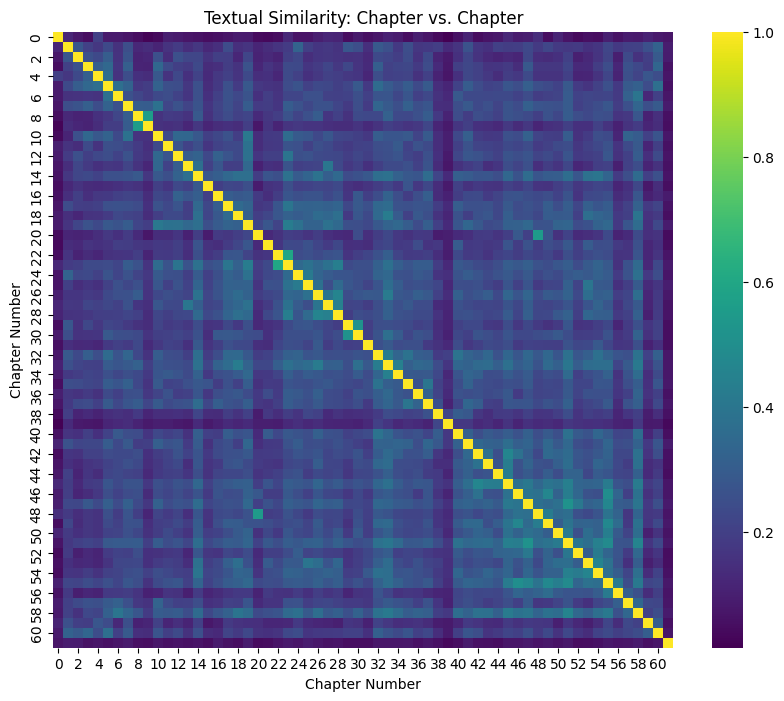

In [3]:
# Initialize the Vectorizer (remove English stop words)
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Transform the text
tfidf_matrix = tfidf.fit_transform(df['text'])

print(f"Matrix Shape: {tfidf_matrix.shape} (Chapters, Unique Words)")

# Calculate Similarity between ALL chapters
similarity_matrix = cosine_similarity(tfidf_matrix)

# Visualize it as a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title("Textual Similarity: Chapter vs. Chapter")
plt.xlabel("Chapter Number")
plt.ylabel("Chapter Number")
plt.show()

**Discussion:** Look at the heatmap. The diagonal line is yellow (perfect similarity with itself).
* Are there "blocks" of yellow? That suggests a group of chapters that stay on the same topic.
* Is there a sharp break where the color changes? That might be where the theme shifts.

## 4. Visualizing Contrast with Scattertext
Now we answer the Underwood question: **What words distinguish the 'Europe' section from the 'Holy Land' section?**

Scattertext will plot words based on how frequently they appear in one category versus the other.

In [4]:
# Create the Scattertext Corpus
corpus = st.CorpusFromPandas(
    df,
    category_col='category',
    text_col='text',
    nlp=nlp
).build()

# Generate the HTML visualization
html = st.produce_scattertext_explorer(
    corpus,
    category='Europe',
    category_name='Europe',       # Y-Axis
    not_category_name='Holy Land', # X-Axis
    width_in_pixels=1000,
    metadata=df['chapter_num']
)

# Save to file (open this in your browser!)
with open("twain_scattertext.html", "w", encoding='utf-8') as f:
    f.write(html)

print("✅ Visualization generated: 'twain_scattertext.html'. Open this file in your folder.")

# If using Colab, you can display it directly:
# display(HTML(html))

✅ Visualization generated: 'twain_scattertext.html'. Open this file in your folder.


## 5. Interpreting the Plot
Open the HTML file.
1.  **Top Left:** Words frequent in **Europe** but rare in the Holy Land.
2.  **Bottom Right:** Words frequent in **Holy Land** but rare in Europe.
3.  **Search:** Type "ruins" or "guides" to see where they fall on the graph.

**The Historical Argument:** Does the vocabulary support the idea that Twain became more cynical? Look for words like "wretched," "dirt," or "heat" in the Holy Land section.